## 导入包

In [1]:
import torch
import torchvision
import torchmetrics
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython import display
from matplotlib_inline import backend_inline
import time
import numpy as np
import ray.tune
import os


## code from d2l

In [2]:
def try_gpu(i=0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def corr2d(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i: i + h, j: j + w] * K).sum()
    return Y

class Conv2d(torch.nn.Module):
    def _init_(self,kernel_size):
        super()._init_()
        self.weight=torch.nn.Parameter(torch.rand(kernel_size))
        self.bias=torch.nn.Parameter(torch.zeros(1))
    def forward(self,x):
        return corr2d(x,self.weight)+self.bias 

class Timer:
    """记录多次运行时间"""
    def __init__(self):
        """Defined in :numref:`subsec_linear_model`"""
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

def use_svg_display():
    backend_inline.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """绘制数据点

    Defined in :numref:`sec_calculus`"""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # 如果X有一个轴，输出True
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

DATA_PATH = './data'

def get_dataloader_workers():
    """使用4个进程来读取数据

    Defined in :numref:`sec_fashion_mnist`"""
    return 4


def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集，然后将其加载到内存中

    Defined in :numref:`sec_fashion_mnist`"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root=DATA_PATH, train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root=DATA_PATH, train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """绘制图像列表

    Defined in :numref:`sec_fashion_mnist`"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_softmax_scratch`"""
        # 增量地绘制多条线
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
    
    def add(self, x, y):
        # 这一部分的目的是，序列化输入x，y
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        # 初始化主类的数据存储
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        # 逐一添加数据
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        # 依次画线，此处应当注意x，y的线的数量超过fmts的长度时，应当自定义self.fmts
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = Accumulator(2)#创建一个累加器，包含2个要累加的元素
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())#把每一组数据预测结果正确的个数和长度累加
    return metric[0] / metric[1]

def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)

    Defined in :numref:`sec_lenet`"""
    def init_weights(m):
        if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = torch.nn.CrossEntropyLoss()
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')


## homework code ch6 sec2

In [3]:
#T1
X = torch.tensor([[0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]])
K = torch.tensor([[1.0, -1.0]])
print(corr2d(X, K))
print(corr2d(X.t(), K))
print(corr2d(X, K.t()))

tensor([[-1.,  1.,  0.,  0.],
        [ 0., -1.,  1.,  0.],
        [ 0.,  0., -1.,  1.],
        [ 0.,  0.,  0., -1.]])
tensor([[ 0.,  0.,  0.],
        [ 1.,  0.,  0.],
        [-1.,  1.,  0.],
        [ 0., -1.,  1.],
        [ 0.,  0., -1.]])
tensor([[ 0.,  1., -1.,  0.,  0.],
        [ 0.,  0.,  1., -1.,  0.],
        [ 0.,  0.,  0.,  1., -1.]])


## homework code ch6 sec3

In [4]:
#T1
X = torch.rand((1, 1, 8, 8))
l = torch.nn.Conv2d(1, 1, (3, 3), 1, 1)
l(X).shape

torch.Size([1, 1, 8, 8])

In [5]:
#T2
l = torch.nn.Conv2d(1, 3, (3, 3), (1, 2), (1, 2))
l(X).shape

torch.Size([1, 3, 8, 5])

## homework code ch6 sec4

In [6]:
def corr2d_matmul(X, K):  
    # 确定输出的形状
    h, w = K.shape
    yh, yw = (X.shape[0] - h + 1, X.shape[1] - w + 1)
    # 展平kernel
    _K = K.flatten()
    # 展平patch
    Y = torch.stack((X[i:i+h, j:j+w].flatten() for i in range(yh) for j in range(yw)), 0)
    return (Y @ _K).reshape(yh, yw)

def corr2d_multi_in_matmul(X, K):
    return sum(corr2d_matmul(x, k) for x, k in zip(X, K))

def corr2d_multi_in_out_matmul(X, K):
    return torch.stack([corr2d_multi_in_matmul(X, k) for k in K], 0)

## homework code ch6 sec5

In [7]:
#T1
X = torch.Tensor([[1,2,3],[4,5,6],[7,8,9]])
K = torch.Tensor([[1/4,1/4],[1/4,1/4]])
corr2d(X,K)

tensor([[3., 4.],
        [6., 7.]])

In [8]:
#T2
X = torch.Tensor([[1,2,3],[4,5,6],[7,8,9]])
K = torch.Tensor([[0, 0],[0, 1]])
corr2d(X,K)

tensor([[5., 6.],
        [8., 9.]])

## homework code ch6 sec6

loss 0.424, train acc 0.844, test acc 0.838
50579.7 examples/sec on cuda:0


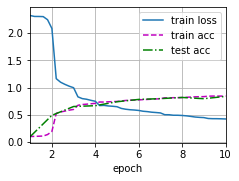

In [9]:
#T1
# 8720 examples/sec on cpu
# 50579.7 examples/sec on gpu
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 6, kernel_size=5, padding=2), torch.nn.Sigmoid(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(6, 16, kernel_size=5), torch.nn.Sigmoid(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Flatten(),
    torch.nn.Linear(16 * 5 * 5, 120), torch.nn.Sigmoid(),
    torch.nn.Linear(120, 84), torch.nn.Sigmoid(),
    torch.nn.Linear(84, 10))

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size=batch_size)
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())


In [10]:
for layer in net:
    print(layer.__class__.__name__) 

Conv2d
Sigmoid
MaxPool2d
Conv2d
Sigmoid
MaxPool2d
Flatten
Linear
Sigmoid
Linear
Sigmoid
Linear


In [11]:
#T2 T3 交给ray tune
# T1 T2 T3
class FlexibleLeNet(torch.nn.Module):
    def __init__(self, activation, fc_layer, cnn_layer, fc_nodes, 
                    cnn_channel, kernel_size, input_size=(1, 28, 28), out_feature=10, **kwargs):
        super().__init__()
        self.cnn_block = torch.nn.ModuleList([])
        self.flatten = torch.nn.Flatten()
        self.fc_block = torch.nn.ModuleList([])
        channel = 1
        for i in range(cnn_layer):
            self.cnn_block.append(torch.nn.Conv2d(in_channels=channel, out_channels=cnn_channel[i],
                                    kernel_size=kernel_size[i], padding='same'))
            self.cnn_block.append(activation())
            self.cnn_block.append(torch.nn.MaxPool2d(2, 2))
            channel = cnn_channel[i]
        in_feature = channel * (input_size[1] // 2**cnn_layer) * (input_size[2] // 2**cnn_layer)
        for i in range(fc_layer):
            self.fc_block.append(torch.nn.Linear(in_feature, fc_nodes[i]))
            self.fc_block.append(activation())
            in_feature = fc_nodes[i]
        self.fc_block.append(torch.nn.Linear(in_feature, out_feature))
    
    def forward(self, x):
        for layer in self.cnn_block:
            x = layer(x)
        x = self.flatten(x)
        for layer in self.fc_block:
            x = layer(x)
        return x

FC_NODES = {0: (), 1: (128, )}
KERNEL_SIZE = {2: (5, 3), 3: (5, 3, 3)}
CHANNEL = {2: (6, 16), 3: (8, 16, 32)}
ACTIVATION = {'elu': torch.nn.ELU, 'relu': torch.nn.ReLU}
search_space = {'lr': ray.tune.loguniform(1e-3, 5e-1),
                'cnn_layer': ray.tune.choice([2, 3]),
                'fc_layer': ray.tune.choice([0, 1]),
                'activation': ray.tune.choice(['relu', 'elu'])}

BATCH_SIZE, EPOCHS = 256, 10
loss = torch.nn.CrossEntropyLoss()
train_iter, test_iter = load_data_fashion_mnist(BATCH_SIZE)
metric = torchmetrics.Accuracy(top_k=1).cuda()

def trainable(config, checkpoint_dir=None):
    net_trial = FlexibleLeNet(ACTIVATION[config['activation']], config['fc_layer'], 
                         config['cnn_layer'], FC_NODES[config['fc_layer']], CHANNEL[config['cnn_layer']], KERNEL_SIZE[config['cnn_layer']])
    def init_weights(m):
        if type(m) == torch.nn.Linear:
            torch.nn.init.xavier_normal_(m.weight)
    net_trial.apply(init_weights)
    if torch.cuda.device_count() > 1:
        net_trial = torch.nn.DataParallel(net_trial)
    net_trial.cuda()
    trainer = torch.optim.SGD(net_trial.parameters(), lr=config['lr'])
    if checkpoint_dir:
        model_state, trainer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net_trial.load_state_dict(model_state)
        trainer.load_state_dict(trainer_state)
    for epoch in range(EPOCHS):
        l = 0
        net_trial.train()
        for X, y in train_iter:
            X, y = X.cuda(), y.cuda()
            pred = net_trial(X)
            loss_val = loss(pred, y)
            metric.update(pred, y)
            l += loss_val.item()
            trainer.zero_grad()
            loss_val.backward()
            trainer.step()
        l /= len(train_iter)
        m = metric.compute().item()
        metric.reset()
        net_trial.eval()
        l = 0
        with torch.no_grad():
            for X, y in test_iter:
                X, y = X.cuda(), y.cuda()
                pred = net_trial(X)
                loss_val = loss(pred, y)
                metric.update(pred, y)
                l += loss_val.item()
            m = metric.compute().item()
            metric.reset()
            l /= len(test_iter)
        ray.tune.report(accuracy=m, loss=l)
        if epoch % 5 == 0:
            with ray.tune.checkpoint_dir(epoch) as checkpoint_dir:
                path = os.path.join(checkpoint_dir, "checkpoint")
                torch.save((net_trial.state_dict(), trainer.state_dict()), path)

analysis = ray.tune.run(trainable, 
                        config=search_space, 
                        resources_per_trial={"cpu": 20, "gpu": 2},
                        num_samples=200,
                        name='homework_ch6',
                        metric='accuracy',
                        mode='max',
                        log_to_file= True,
                        local_dir='./ray_result',
                        scheduler=ray.tune.schedulers.ASHAScheduler(
                                            max_t=50,
                                            grace_period=5,
                                            reduction_factor=2),
                        verbose=0,
                        max_failures=1,
                        resume='AUTO')

2022-06-02 21:15:27,482	INFO trial_runner.py:803 -- starting trainable_29bdd_00115
(pid=) 2022-06-02 21:15:27,829	INFO context.py:67 -- Exec'ing worker with command: "C:\ProgramData\Anaconda3\python.exe" Z:\User\Documents\Python\Python39\site-packages\ray\workers/default_worker.py --node-ip-address=127.0.0.1 --node-manager-port=59888 --object-store-name=tcp://127.0.0.1:64273 --raylet-name=tcp://127.0.0.1:60091 --redis-address=None --storage=None --temp-dir=C:\Users\zhulei\AppData\Local\Temp\26\ray --metrics-agent-port=61220 --logging-rotate-bytes=536870912 --logging-rotate-backup-count=5 --gcs-address=127.0.0.1:60314 --redis-password=5241590000000000 --startup-token=134 --runtime-env-hash=-354594111
2022-06-02 21:15:28,504	WARNING util.py:171 -- The `start_trial` operation took 1.021 s, which may be a performance bottleneck.
(trainable pid=22380) C:\ProgramData\Anaconda3\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
(trainable pid=22380

In [15]:
print(analysis.best_config)

{'lr': 0.30494526025156204, 'cnn_layer': 2, 'fc_layer': 1, 'activation': 'elu'}


In [19]:
overall = analysis.dataframe()[['accuracy', 'loss', 'config/activation', 'config/fc_layer', 'config/cnn_layer', 'config/lr']]
overall['activation'] = overall['config/activation'].map(lambda s: 1 if s == 'elu' else 0)
overall

,accuracy,loss,config/activation,config/fc_layer,config/cnn_layer,config/lr,activation
0,0.8943,0.305431,elu,1,3,0.311434,1
1,0.7884,0.565115,elu,1,2,0.020866,1
2,0.7165,0.800565,elu,1,2,0.001809,1
3,0.7521,0.601713,relu,0,2,0.028960,0
4,0.5865,1.269426,relu,1,3,0.001766,0
...,...,...,...,...,...,...,...
195,0.8596,0.376769,relu,1,3,0.047459,0
196,0.8469,0.405294,relu,0,3,0.099353,0
197,0.8725,0.356891,elu,1,2,0.048280,1
198,0.1000,150.761337,elu,0,2,0.378909,1


<AxesSubplot:xlabel='config/lr', ylabel='accuracy'>

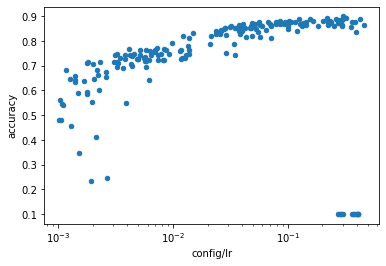

In [20]:
overall.plot(x='config/lr', y='accuracy', logx=True, kind='scatter')

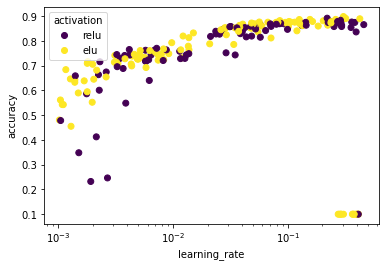

In [21]:
scatter = plt.scatter(data=overall, x='config/lr', y='accuracy', c='activation')
plt.gca().set_xscale('log')
plt.gca().set_xlabel('learning_rate')
plt.gca().set_ylabel('accuracy')
plt.legend(scatter.legend_elements()[0], ['relu', 'elu'], title='activation')
plt.show()

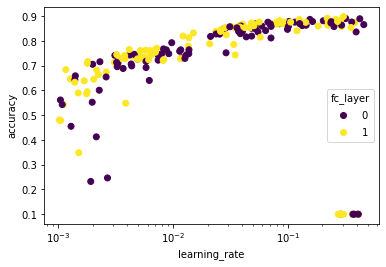

In [22]:
scatter = plt.scatter(data=overall, x='config/lr', y='accuracy', c='config/fc_layer')
plt.gca().set_xscale('log')
plt.gca().set_xlabel('learning_rate')
plt.gca().set_ylabel('accuracy')
plt.legend(*scatter.legend_elements(), title='fc_layer')
plt.show()

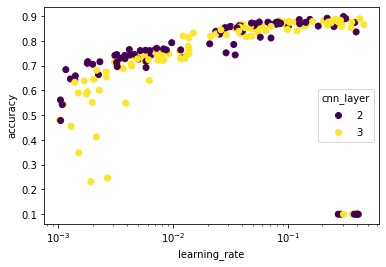

In [24]:
scatter = plt.scatter(data=overall, x='config/lr', y='accuracy', c='config/cnn_layer')
plt.gca().set_xscale('log')
plt.gca().set_xlabel('learning_rate')
plt.gca().set_ylabel('accuracy')
plt.legend(*scatter.legend_elements(), title='cnn_layer')
plt.show()

Conv2d layer output:	 [[[[ 0.48179337  0.48179337  0.48179337 ...  0.48179337  0.48179337
     0.48179337]
   [ 0.48179337  0.48179337  0.48179337 ...  0.48179337  0.48179337
     0.48179337]
   [ 0.48179337  0.48179337  0.48179337 ...  0.48179337  0.48179337
     0.48179337]
   ...
   [ 0.48179337  0.48179337  0.48179337 ...  0.48179337  0.48179337
     0.48179337]
   [ 0.48179337  0.48179337  0.48179337 ...  0.48179337  0.48179337
     0.48179337]
   [ 0.48179337  0.48179337  0.48179337 ...  0.48179337  0.48179337
     0.48179337]]

  [[ 0.8216998   0.8216998   0.8216998  ...  0.8216998   0.8216998
     0.8216998 ]
   [ 0.8216998   0.8216998   0.8216998  ...  0.8216998   0.8216998
     0.8216998 ]
   [ 0.8216998   0.8216998   0.8216998  ...  0.8216998   0.8216998
     0.8216998 ]
   ...
   [ 0.8216998   0.8216998   0.8216998  ...  0.8216998   0.8216998
     0.8216998 ]
   [ 0.8216998   0.8216998   0.8216998  ...  0.8216998   0.8216998
     0.8216998 ]
   [ 0.8216998   0.8216998   0.8

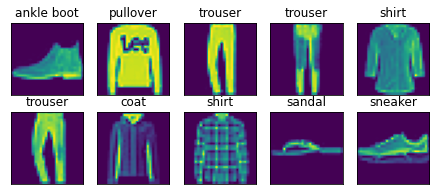

In [14]:
#T4
for imgs, labels in test_iter:
    show_images(imgs[:10, 0], 2, 5, get_fashion_mnist_labels(labels[:10]))
    X = imgs[:2].cuda()
    for layer in net:
        X = layer(X)
        print(layer.__class__.__name__, 'layer output:\t', X.cpu().detach().numpy()) 
    break